In [1]:
import sys
sys.path.append("../../")

# Reproduction of Figure 3 using a GP model

Here I reproduce Figure 3 of Garnelo et al.'s article, using a Gaussian Process (GP) model instead of a Neural Process (NP). 
This mainly serves as a sanity check and a proof of concept for the general structure of my code.

In [2]:
import tensorflow as tf

from neuralprocesses.np.aux import DataProvider
from neuralprocesses.utils.gp import GaussianProcess
from neuralprocesses.utils.gp import squared_exponential_kernel

We sample functions from a GP with a squared-exponential kernel. For the latter, the correlation length is 2, and the other parameters are default values.

In [3]:
kernel = lambda x: squared_exponential_kernel(x, 2.)
distribution = lambda x: GaussianProcess((None, x), kernel, name="distr")

Now we construct the `DataProvider` module, which acts as an interface between the distribution and the model.

In [4]:
data_provider = DataProvider(distribution, batch_size=1, domain=(-2, 2))

The `data_provider` now generates `batch_size=1` example ground truth functions, sampled from the `distribution`.
All context and target points are provided by the `.data` property. In plotting mode (i.e. we set `data_provider.plotting_mode: True` in the `feed_dict` later on), the context points are all the target points, but randomly shuffled.

In [5]:
((x_context, y_context), x_target) = data_provider.data.queries
y_target = data_provider.data.targets

Now that we have generated a ground truth function in terms of target points, we can prepare our model. 
Since we wish to generate several samples from the model for the _same_ ground truth function, we inflate the target (and context) point sets to create batches of equal data.

In [6]:
SAMPLE_SIZE = 5

# Repeat all target points SAMPLE_SIZE times (so we generate that many samples for the same ground truth function)
x_target = tf.reshape(tf.transpose(tf.stack([x_target] * SAMPLE_SIZE), perm=[1, 0, 2]), (SAMPLE_SIZE, -1))
y_target = tf.reshape(tf.transpose(tf.stack([y_target] * SAMPLE_SIZE), perm=[1, 0, 2]), (SAMPLE_SIZE, -1))

# Do the same with the context points, since batch dimensions must match
x_context = tf.reshape(tf.transpose(tf.stack([x_context] * SAMPLE_SIZE), perm=[1, 0, 2]), (SAMPLE_SIZE, -1))
y_context = tf.reshape(tf.transpose(tf.stack([y_context] * SAMPLE_SIZE), perm=[1, 0, 2]), (SAMPLE_SIZE, -1))

In contrast to the NP model, the GP model does not need to be trained, since we use the same kernel for data generation and for the model.
Thus, we create a GP model and provide it with the context points, as well as the `kernel` defined above.

In [7]:
model = GaussianProcess(((x_context, y_context), x_target), kernel, name="model")

Arrange data for plotting.

In [8]:
# Transform to [B, n, 2] tensor, where n is the number of points in each batch
context_points = tf.transpose([x_context, y_context], perm=[1, 2, 0])
target_points  = tf.transpose([x_target, y_target], perm=[1, 2, 0])
predictions = tf.transpose([x_target, model.sample], perm=[1, 2, 0])

The computational graph is now complete. Let's generate a ground truth function.

In [9]:
with tf.Session() as session:
    xc, yc, xt, yt = session.run(
        [x_context, y_context, x_target, y_target], 
        feed_dict={
            data_provider.plotting_mode: True
        })

We sample `SAMPLE_SIZE` functions from the conditioned GP model and compare them visually to the ground truth function, using different numbers of context points.

In [10]:
with tf.Session() as session:
    
    results = [
        session.run(
            [predictions, target_points, context_points], 
            feed_dict={
                x_context: xc[:,:i],
                y_context: yc[:,:i],
                x_target: xt,
                y_target: yt
            })
        for i in [1, 2, 10]
    ]

Finally, we plot the results.

In [11]:
from neuralprocesses.utils.plotting import list_plot
from neuralprocesses.utils.plotting import Color
import numpy as np

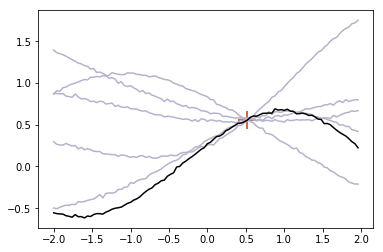

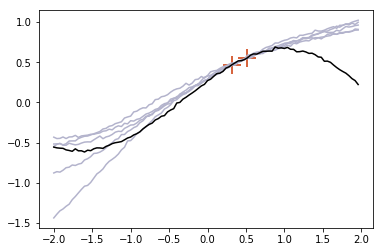

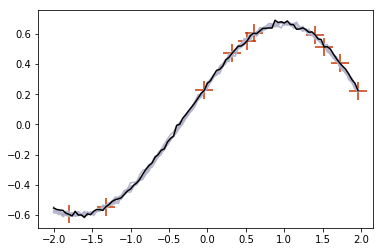

In [12]:
for result in results:
    p, t, c = result

    list_plot([p[0], p[1], p[2], p[3], p[4], t[0], c[0]], 
              joined=[True,True,True,True,True,True,False], 
              mesh=[False,False,False,False,False,False,True],
              plot_style=[
                  Color((0.7,0.7,0.8)),  # Gray-blue samples from the GP model
                  Color((0.7,0.7,0.8)),
                  Color((0.7,0.7,0.8)),
                  Color((0.7,0.7,0.8)),
                  Color((0.7,0.7,0.8)),
                  Color((0.,0.,0.)),     # Black ground truth
                  {"Color": Color.color_data(n=0), "PointSize": 350, "Marker": "+"}  # Red + for context points
              ]
             )